*This notebook contains our novel architecture for a VAE that generates (T2, Tumour mask) pairs. That is, we can generate not only the T2-weighted MRI, but also the corresponding tumour masks that belongs to that augmented T2. This overcomes the problem of our augmented data not having the corresponding tumour pixel labels*. 

###1. [Set up the Dataloaders](#scrollTo=XK_L9BKp5wpX&line=1&uniqifier=1)

###2. [VAE architecture](#scrollTo=IX_AV6trzMig&line=1&uniqifier=1)

###3. [Visualise some results](#scrollTo=kvYGZl5h1Awb&line=1&uniqifier=1)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#no need to use GPU yet, since not using any GPU-accelerated libraries: 
#https://stackoverflow.com/questions/61360422/anyone-experienced-the-warning-about-google-colaboratoryyou-are-connected-to-a

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
#https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install platipy
# import SimpleITK as sitk
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import seaborn as sns
import pandas as pd

import torchvision
from torch.utils.data import Dataset

In [3]:
#download final output from Section 2 of ISPY_processing.ipynb
import gdown 

gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=18UiIIxQF8jtIZWYI3pkEaoAhZjDkLgmo","t1_arraysstan_32.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1--LgF7Ka9LiPvl6ANbDPHKpwO-4F__Y_","t2_arraysstan_32.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1-19CAZ8k1gWVaNCNbjbZfJz5ZJERFjx7","mask_arrayscropped_8.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1A8Ghp8bJExZenndd7P43t9GE0JuX41iC","patient_labels.pkl") #need patient labels for pytorch train/test split later

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=18UiIIxQF8jtIZWYI3pkEaoAhZjDkLgmo
To: /content/t1_arraysstan_32.pkl
100%|██████████| 981M/981M [00:05<00:00, 194MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1--LgF7Ka9LiPvl6ANbDPHKpwO-4F__Y_
To: /content/t2_arraysstan_32.pkl
100%|██████████| 981M/981M [00:13<00:00, 71.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-19CAZ8k1gWVaNCNbjbZfJz5ZJERFjx7
To: /content/mask_arrayscropped_8.pkl
100%|██████████| 245M/245M [00:01<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1A8Ghp8bJExZenndd7P43t9GE0JuX41iC
To: /content/patient_labels.pkl
100%|██████████| 4.85k/4.85k [00:00<00:00, 3.63MB/s]


'patient_labels.pkl'

In [4]:
!ls 

drive			  patient_labels.pkl  t1_arraysstan_32.pkl
mask_arrayscropped_8.pkl  sample_data	      t2_arraysstan_32.pkl


In [5]:
import pickle

#load the files into namespace
with open('/content/t1_arraysstan_32.pkl', 'rb') as f: 
    t1_arrays = pickle.load(f)

with open('/content/t2_arraysstan_32.pkl', 'rb') as f: 
    t2_arrays = pickle.load(f)

with open('/content/mask_arrayscropped_8.pkl', 'rb') as f: 
    mask_arrays = pickle.load(f)

with open('/content/patient_labels.pkl', 'rb') as f:
    patient_labels = pickle.load(f)

## Set up DataLoaders

In [24]:
def show_slice(t1, t2, mask):
  #args are ndarrays
  fig, ax = plt.subplots(nrows=1, ncols = 3,
                         figsize=(10,5), sharey = True)
  fig.tight_layout()

  ax[0].set_title("T1"); ax[0].imshow(t1)
  ax[1].set_title("T2"); ax[1].imshow(t2)
  ax[2].set_title("mask"); ax[2].imshow(mask)

In [17]:
train_prop = 0.8 #take 0.8 of patients for training

import random; random.seed(4) 
unique_p = list(dict.fromkeys(patient_labels)) #preserve order
train_p = random.sample(unique_p, 
                        int(train_prop*len(unique_p)))
print(len(train_p))

train_indexes = [e in train_p for e in patient_labels]
print("train prop:", sum(train_indexes)/len(train_indexes),
      "train size:", sum(train_indexes)) #0.8 of the data for training

81
train prop: 0.8102872411489646 train size: 1213


In [18]:
def get_train_slices(t1_arrays, t2_arrays, mask_arrays, train_indexes):
  z_dim = len(train_indexes)
  test_indexes = [not e for e in train_indexes]
  return t1_arrays[train_indexes], t2_arrays[train_indexes], mask_arrays[train_indexes], t1_arrays[test_indexes], t2_arrays[test_indexes], mask_arrays[test_indexes]


train_t1, train_t2, train_mask, test_t1, test_t2, test_mask = get_train_slices(t1_arrays, t2_arrays, mask_arrays, train_indexes)
print(train_t1.shape)
print(test_t1.shape)

(1213, 320, 512)
(284, 320, 512)


In [19]:
class ISPY_dataset(Dataset):

  def __init__(self, t1_arrays, t2_arrays, mask_arrays,
                     transforms):
    self.t1_arrays = t1_arrays
    self.t2_arrays = t2_arrays
    self.mask_arrays = mask_arrays
    self.transforms = transforms

  def __len__(self):
    return self.t1_arrays.shape[0]

  def __getitem__(self, idx):
    t1 = t1_arrays[idx]; t2 = t2_arrays[idx]; mask = mask_arrays[idx]

    ##transform the T1 and T2
    if self.transforms is not None: 
      t1 = self.transforms(t1)
      t2 = self.transforms(t2)
      mask = self.transforms(mask)

    return (torch.cat([t2, mask], dim = 0), t1) #t1 and t2 in each channel

In [20]:
# define transformations for T1 and T2
my_transforms = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
  torchvision.transforms.Resize((128, 128))
  ])

train_data = ISPY_dataset(train_t1, train_t2, train_mask, 
                          my_transforms)

test_data = ISPY_dataset(test_t1, test_t2, test_mask, 
                          my_transforms)

torch.set_printoptions(edgeitems=3)
print(train_data[0]) # t2_mask, t1
print(train_data[0][0].shape) #each image has 2 channels, and is 512 x 512

(tensor([[[-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         ...,
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]), tensor([[[-0.7590, -0.7590, -0.7590,  ..., -0.7590, -0.7590, -0.7590],
         [-0.7590, -0.7590, -0.7590,  ..., 

In [21]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size = 128, shuffle=True);
test_loader = DataLoader(test_data, batch_size = 128, shuffle=True)

In [22]:
torch.manual_seed(3)
t2_mask, t1 = next(iter(train_loader))
print(t2_mask.shape)

torch.Size([128, 2, 128, 128])


In [ ]:
#get just mask
# masks = torch.index_select(t2_mask, dim = 1, index = torch.tensor([1]))
# masks.shape

torch.Size([128, 1, 128, 128])

## Architecture of the VAE on T2 and Masks

In [23]:
def dice_loss(input, target):
  #input and target are tensors
    smooth = 1.

    iflat = input #iflat = input.view(-1)
    tflat = target#tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth)) #dice loss is 1-dice coeff

In [25]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(2, 8, kernel_size = 3, stride = 2, padding = 1) #increase the number of channels
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(16)

        #mean and stds
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1)

        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x))); x = self.pool(x)

        x = F.leaky_relu(self.bn2(self.conv2(x))); x = self.pool(x)

        mu =  self.conv3(x)
        sigma = torch.exp(self.conv4(x)) #exponential activation to ensure positive
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2)
        return z

In [26]:
from torchinfo import summary

summary(VariationalEncoder(), input_size= t2_mask.shape)

Layer (type:depth-idx)                   Output Shape              Param #
VariationalEncoder                       [128, 32, 4, 4]           --
├─Conv2d: 1-1                            [128, 8, 64, 64]          152
├─BatchNorm2d: 1-2                       [128, 8, 64, 64]          16
├─MaxPool2d: 1-3                         [128, 8, 32, 32]          --
├─Conv2d: 1-4                            [128, 16, 16, 16]         1,168
├─BatchNorm2d: 1-5                       [128, 16, 16, 16]         32
├─MaxPool2d: 1-6                         [128, 16, 8, 8]           --
├─Conv2d: 1-7                            [128, 32, 4, 4]           4,640
├─Conv2d: 1-8                            [128, 32, 4, 4]           4,640
Total params: 10,648
Trainable params: 10,648
Non-trainable params: 0
Total mult-adds (M): 136.98
Input size (MB): 16.78
Forward/backward pass size (MB): 76.55
Params size (MB): 0.04
Estimated Total Size (MB): 93.37

In [27]:
class T2_Decoder(nn.Module):
    def __init__(self):
        super(T2_Decoder, self).__init__()
        self.convt1 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(16)

        self.convt2 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 4, padding = 1,  output_padding = 1)
        self.bn2 = nn.BatchNorm2d(8)

        self.convt3 = nn.ConvTranspose2d(8, 1, kernel_size = 5,  stride = 4, padding = 1, output_padding = 1) #undo the maxpool and conv
        self.bn3 = nn.BatchNorm2d(1)

    def forward(self, z):
        z = F.leaky_relu(self.bn1(self.convt1(z)))

        z = F.leaky_relu(self.bn2(self.convt2(z)))
        
        z = self.bn3(self.convt3(z))
        
        x = z 
        #new idea: drop the activation entirely! https://qr.ae/pr5s0Y
        return x

class Mask_Decoder(nn.Module):
    def __init__(self):
        super(Mask_Decoder, self).__init__()
        self.convt1 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(16)

        self.convt2 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 4, padding = 1,  output_padding = 1)
        self.bn2 = nn.BatchNorm2d(8)

        self.convt3 = nn.ConvTranspose2d(8, 1, kernel_size = 5,  stride = 4, padding = 1, output_padding = 1) #undo the maxpool and conv
        self.bn3 = nn.BatchNorm2d(1)

    def forward(self, z):
        z = F.leaky_relu(self.bn1(self.convt1(z)))

        z = F.leaky_relu(self.bn2(self.convt2(z)))
        
        logits = self.convt3(z)
        p = torch.sigmoid(logits) #for when DICE
        return p



In [28]:
#summary(T2_Decoder(), input_size= (128, 32, 4, 4))
summary(Mask_Decoder(), input_size= (128, 32, 4, 4))

Layer (type:depth-idx)                   Output Shape              Param #
Mask_Decoder                             [128, 1, 128, 128]        2
├─ConvTranspose2d: 1-1                   [128, 16, 8, 8]           4,624
├─BatchNorm2d: 1-2                       [128, 16, 8, 8]           32
├─ConvTranspose2d: 1-3                   [128, 8, 32, 32]          3,208
├─BatchNorm2d: 1-4                       [128, 8, 32, 32]          16
├─ConvTranspose2d: 1-5                   [128, 1, 128, 128]        201
Total params: 8,083
Trainable params: 8,083
Non-trainable params: 0
Total mult-adds (M): 879.89
Input size (MB): 0.26
Forward/backward pass size (MB): 35.65
Params size (MB): 0.03
Estimated Total Size (MB): 35.95

In [29]:
#change out the Encoder for Variational Encoder
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.t2_decoder = T2_Decoder()
        self.mask_decoder = Mask_Decoder()

    def forward(self, x):
        z = self.encoder(x)
        return torch.cat([self.t2_decoder(z), self.mask_decoder(z)], dim = 1)

In [ ]:
summary(VariationalAutoencoder(), input_size = t2_mask.shape)

Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [128, 2, 128, 128]        --
├─VariationalEncoder: 1-1                [128, 32, 4, 4]           --
│    └─Conv2d: 2-1                       [128, 8, 64, 64]          152
│    └─BatchNorm2d: 2-2                  [128, 8, 64, 64]          16
│    └─MaxPool2d: 2-3                    [128, 8, 32, 32]          --
│    └─Conv2d: 2-4                       [128, 16, 16, 16]         1,168
│    └─BatchNorm2d: 2-5                  [128, 16, 16, 16]         32
│    └─MaxPool2d: 2-6                    [128, 16, 8, 8]           --
│    └─Conv2d: 2-7                       [128, 32, 4, 4]           4,640
│    └─Conv2d: 2-8                       [128, 32, 4, 4]           4,640
├─T2_Decoder: 1-2                        [128, 1, 128, 128]        --
│    └─ConvTranspose2d: 2-9              [128, 16, 8, 8]           4,624
│    └─BatchNorm2d: 2-10                 [128, 16, 8, 8]           32
│ 

In [30]:
def validate_one_epoch(autoencoder, loader, recon_loss_fn, mask_loss_fn):
    #validate results on the validation loader
    
    autoencoder.eval()# Set model to evaluation mode
    num_samples = len(loader.dataset) 
    
    mse_t2 = 0.0; dice = 0.0; kl = 0.0
    
    latent_dim = None
    for i, (t2_mask, t1) in enumerate(loader):

        t2_mask = t2_mask.to(device);  t1 = t1.to(device)
        
        with torch.no_grad():  # sure that we will not backpropagate
            
            if latent_dim is None:
              latent_dim = torch.tensor(autoencoder.encoder(t2_mask).shape)
              
            # Prediction
            t2_mask_hat = autoencoder(t2_mask) 

            mse_t2 += recon_loss_fn(t2_mask_hat[:,0,:,:], t2_mask[:,0,:,:])*(t2_mask.shape[0]/num_samples) #e.g MSE takes the mean already
            dice += mask_loss_fn(t2_mask_hat[:,1,:,:], t2_mask[:,1,:,:])*(t2_mask.shape[0]/num_samples)
         
            #am I even calculating kl properly?
            kl += autoencoder.encoder.kl.sum()/t1.shape[0] #sum over [128, 128,   5,   5], then divide by batch size. i.e. average TOTAL kl per image

    #mse = mse/(num_samples*256*256) #then average
    kl = kl/(torch.prod(latent_dim[1:]).item())
    return  mse_t2, dice, kl

In [31]:
#early stopper https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            print("validation didn't improve")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
#train over epochs of the training set

def train(autoencoder, data, valid_data, epochs=3, lr = 0.003, recon_loss_fn = F.mse_loss, mask_loss_fn = dice_loss):
    #early_stopper = EarlyStopper(patience=3, min_delta = 0.0) # if validation loss > min validation loss + min_delta, start counting

    opt = torch.optim.Adam(autoencoder.parameters(), lr) #default lr = 0.001

    # Initialise table to track training
    num_samples = len(data.dataset)
    table = pd.DataFrame(np.arange(1, epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0
    table['valid loss'] = 0.0

    for epoch in range(epochs):
      print("epoch:", epoch)
      train_loss = 0.0

      for i, (t2_mask, t1) in enumerate(data):
            t2_mask = t2_mask.to(device) # GPU
           
            opt.zero_grad()
            t2_mask_hat = autoencoder(t2_mask) 

            reconstruction_t2 = recon_loss_fn(t2_mask_hat[:,0,:,:], t2_mask[:,0,:,:], )
           
            #masks = torch.index_select(t2_mask, dim = 1, index = torch.tensor([1]))
            dice = mask_loss_fn(t2_mask_hat[:,1,:,:], t2_mask[:,1,:,:], )
            kl = autoencoder.encoder.kl.mean()
            loss = reconstruction_t2 + dice + kl 
            
            print("batch {} loss: {:.5} MSE t2 {:.4}, Dice {:.4}, KL {:.4}".format(i, loss.item(), reconstruction_t2, dice, kl.item()))

            loss.backward()
            opt.step()

             # Training set metrics   
            with torch.no_grad(): 
                
                l = loss.cpu().detach().numpy()
                train_loss +=  l*(t1.shape[0]/num_samples)

      valid_mse_t2, valid_dice, valid_kl = validate_one_epoch(autoencoder, valid_data, recon_loss_fn, mask_loss_fn)
      print("validation loss {:.5} MSE t2 {:.4} DICE {:.4} KL {:.4}\n".format(valid_mse_t2 + valid_dice + valid_kl, valid_mse_t2, valid_dice, valid_kl) )

      table.iloc[epoch, 1] = np.round(train_loss, 3)
      table.iloc[epoch, 2] = np.round((valid_mse_t2 + valid_dice + valid_kl).item(), 3)

      # if early_stopper.early_stop(valid_mse + valid_kl):             
      #   break
            
    return autoencoder, table

torch.manual_seed(4) # 3 is a bad seed for mean, std normalised data. used 4

vae = VariationalAutoencoder().to(device) 
vae, table = train(vae, train_loader, test_loader, epochs = 60, lr = 0.01) #0.01

epoch: 0
batch 0 loss: 7.4333 MSE t2 2.027, Dice 0.9965, KL 4.41
batch 1 loss: 4.2639 MSE t2 1.893, Dice 0.9963, KL 1.375
batch 2 loss: 3.9665 MSE t2 1.732, Dice 0.9957, KL 1.239
batch 3 loss: 3.7877 MSE t2 1.546, Dice 0.996, KL 1.246
batch 4 loss: 3.5339 MSE t2 1.243, Dice 0.9964, KL 1.295
batch 5 loss: 3.3886 MSE t2 1.079, Dice 0.9959, KL 1.313
batch 6 loss: 3.1989 MSE t2 0.8918, Dice 0.9949, KL 1.312
batch 7 loss: 3.1127 MSE t2 0.8186, Dice 0.9943, KL 1.3
batch 8 loss: 3.0317 MSE t2 0.7523, Dice 0.9955, KL 1.284
batch 9 loss: 2.9532 MSE t2 0.6911, Dice 0.9946, KL 1.267
validation loss 6.7098 MSE t2 1.107 DICE 0.9932 KL 4.61

epoch: 1
batch 0 loss: 3.5513 MSE t2 1.05, Dice 0.9947, KL 1.507
batch 1 loss: 3.1423 MSE t2 0.9274, Dice 0.9947, KL 1.22
batch 2 loss: 3.0534 MSE t2 1.014, Dice 0.9971, KL 1.042
batch 3 loss: 2.857 MSE t2 1.011, Dice 0.9957, KL 0.8506
batch 4 loss: 2.6554 MSE t2 0.9857, Dice 0.9954, KL 0.6743
batch 5 loss: 2.5252 MSE t2 0.9866, Dice 0.9961, KL 0.5424
batch 6 lo

## Results

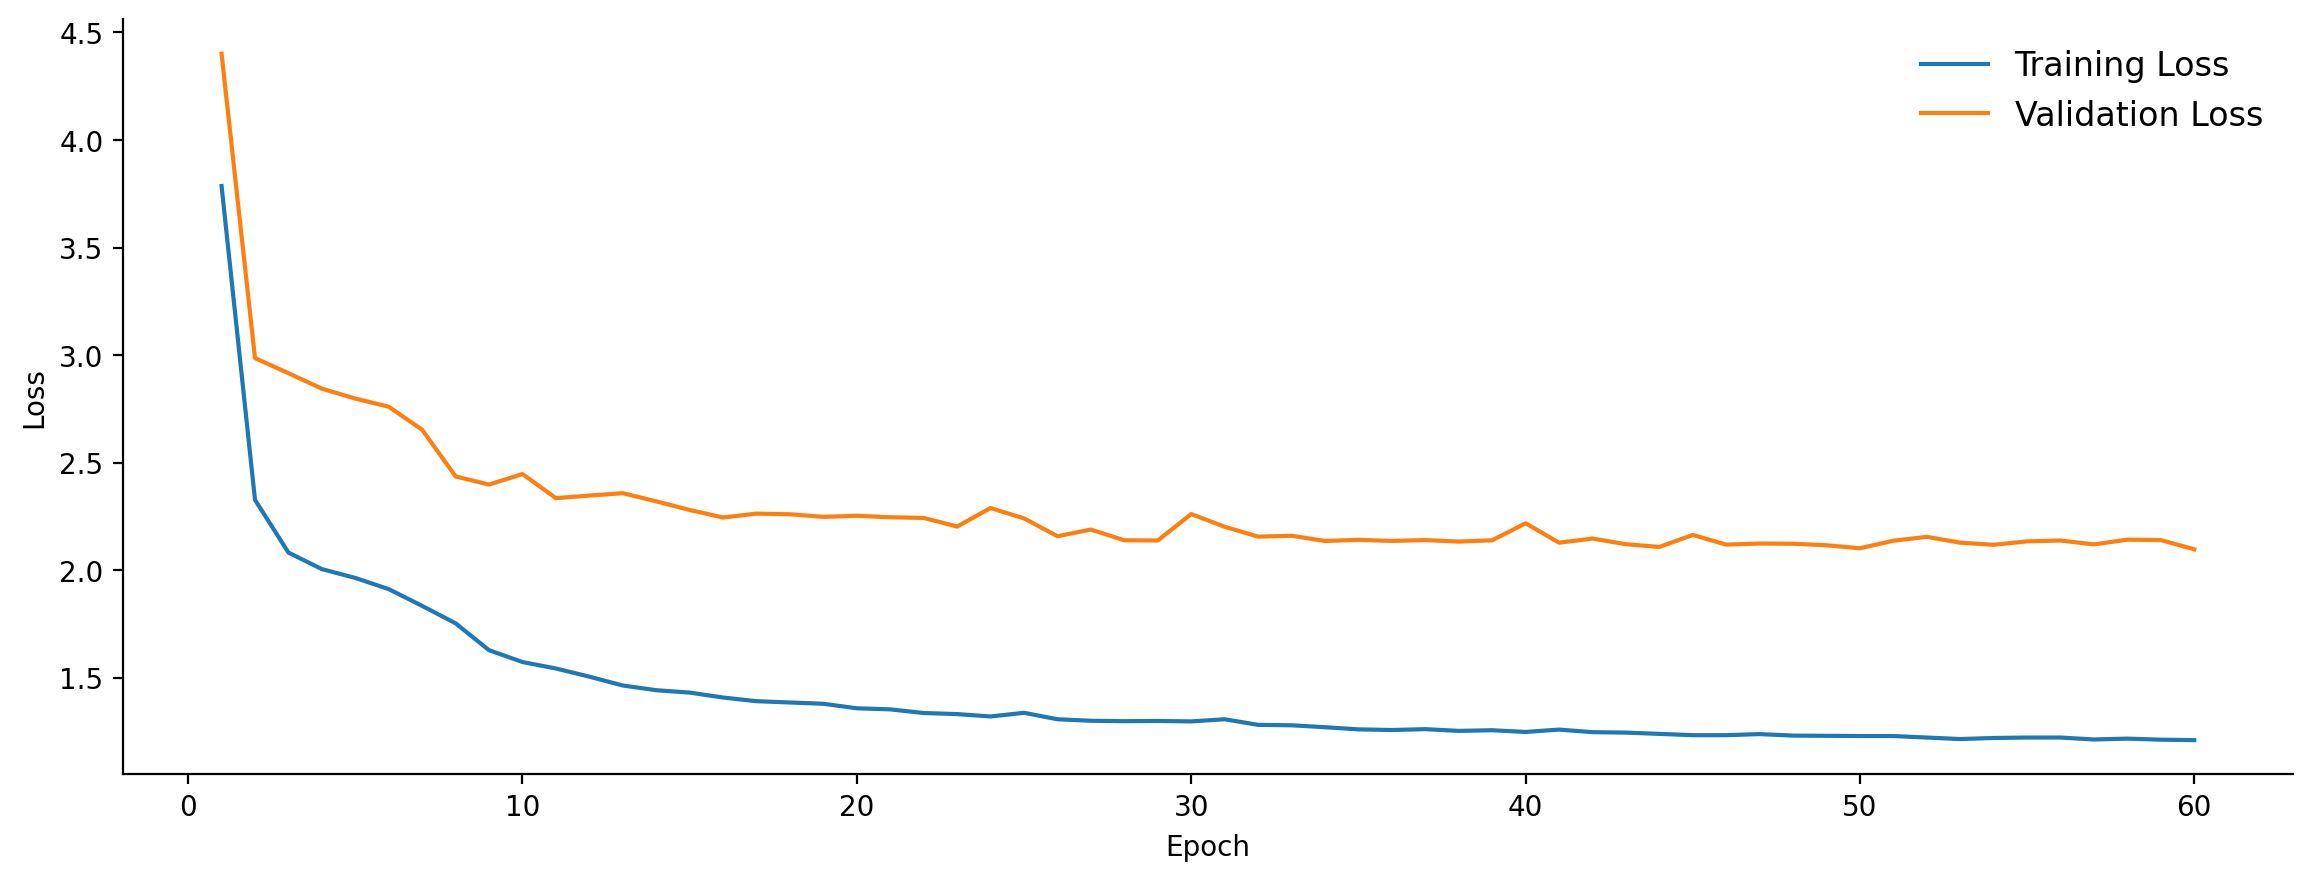

In [ ]:
fig , axes = plt.subplots(1, 1, figsize=(14, 5))

axes.plot(table['epoch'], table['train loss'], label = 'Training Loss')
axes.plot(table['epoch'], table['valid loss'], label = 'Validation Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.legend(fontsize=12, frameon=False)

sns.despine()
plt.show()

In [ ]:
torch.manual_seed(3)
(t2_mask, t1)= next(iter(train_loader)) #get one batch
t2_mask = t2_mask.to(device)
reconstructions = vae(t2_mask)

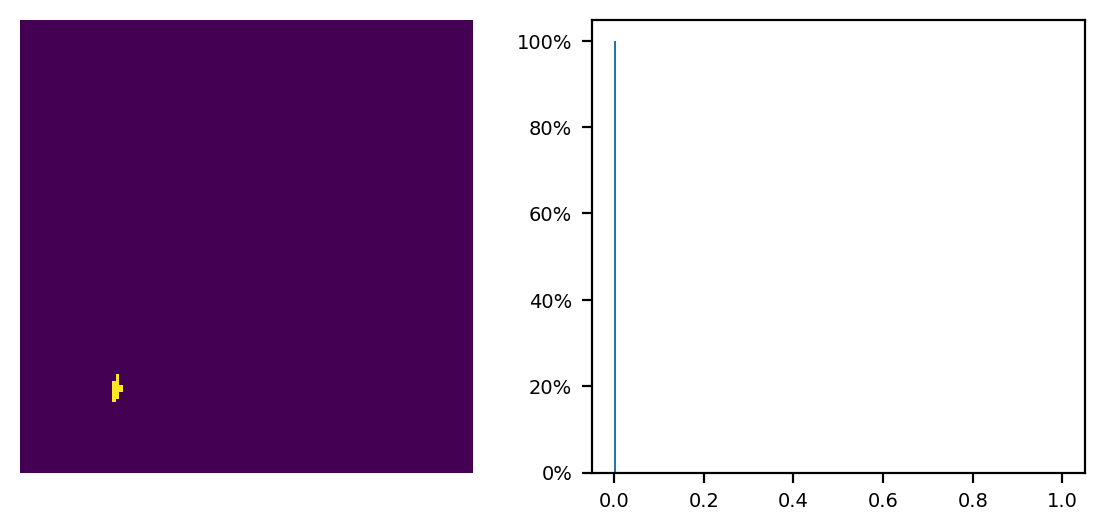

In [ ]:
import matplotlib.ticker 
from matplotlib.ticker import PercentFormatter

def plot_hist(img, vmin = None, vmax = None):
  fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (7,3))
  if vmin is None and vmax is None: 
    ax1.imshow(img); ax1.axis("off")

  else:
    ax1.imshow(img, vmin = vmin, vmax = vmax); ax1.axis("off")

  intensities = img.ravel()
  ax2.hist(intensities, weights=np.ones(len(intensities)) / len(intensities), bins = 256)
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1)); plt.show()


masks =  torch.index_select(t2_mask, dim = 1, index = torch.tensor([1]))
t2s = torch.index_select(t2_mask, dim = 1, index = torch.tensor([0]))

plot_hist(masks[0][0])

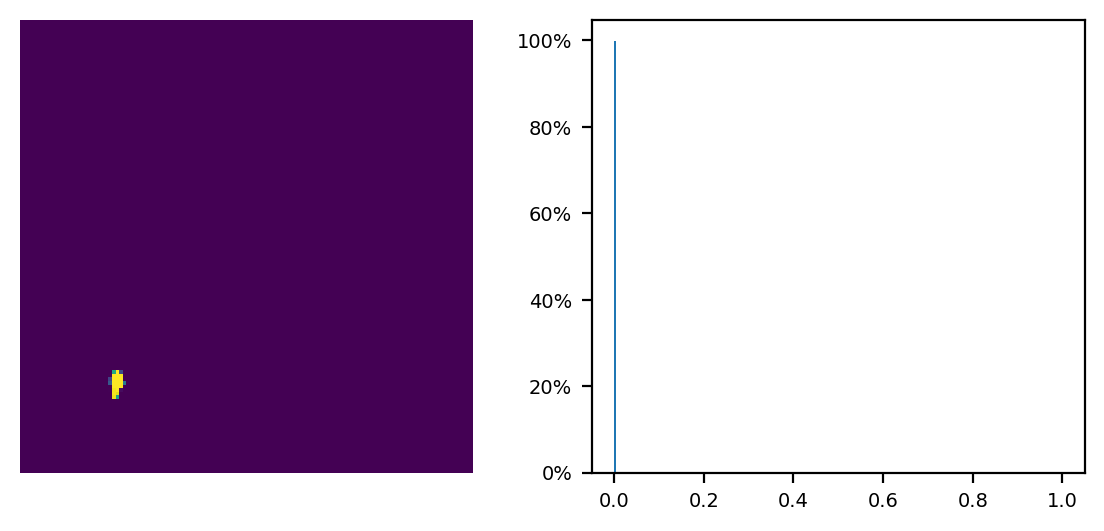

In [ ]:
recon_masks =  torch.index_select(reconstructions.detach(), dim = 1, index = torch.tensor([1]))
plot_hist(recon_masks[0][0])

In [ ]:
def show_subplot(t2, mask, t2h, maskh):
    plt.rcParams.update({'font.size': 7})
    plt.figure(figsize=(3, 3))
    plt.subplot(2, 2, 1); plt.title("T2"); plt.axis("off")
    plt.imshow(t2)
    
    plt.subplot(2, 2, 2); plt.title("Mask"); plt.axis("off")
    plt.imshow(mask)

    plt.subplot(2, 2, 3); plt.title("Reconstructed T2"); plt.axis("off")
    plt.imshow(t2h, vmin = torch.min(t2), vmax = torch.max(t2))

    plt.subplot(2, 2, 4); plt.title("Reconstructed Mask"); plt.axis("off")
    plt.imshow(maskh, vmin = torch.min(mask), vmax = torch.max(mask))
    
    plt.show()

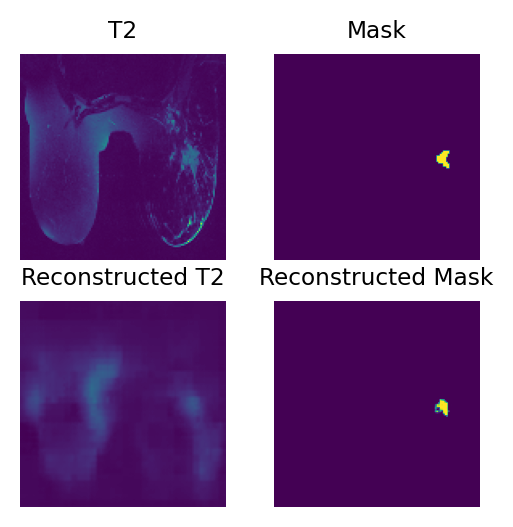

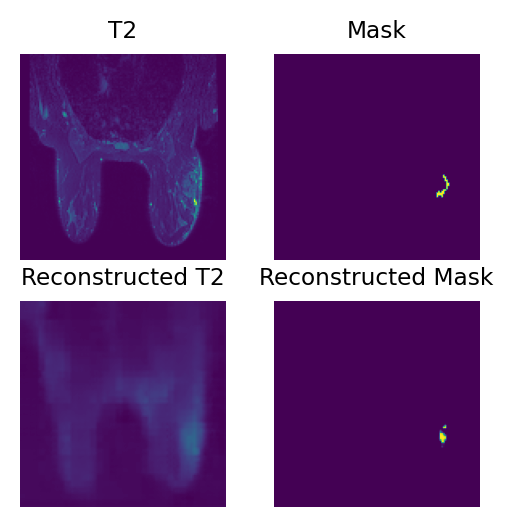

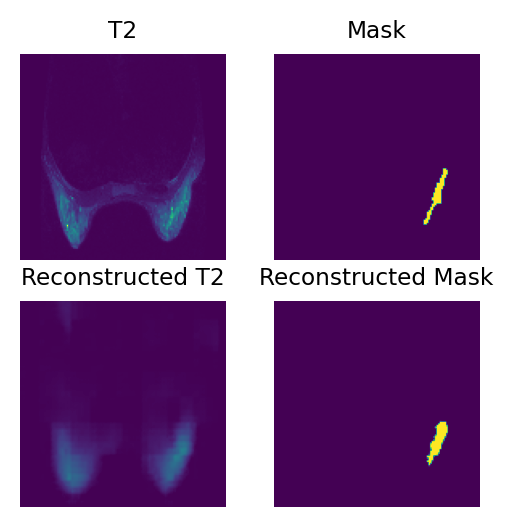

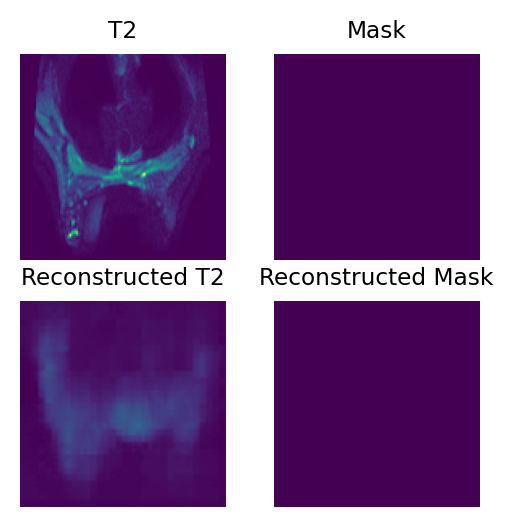

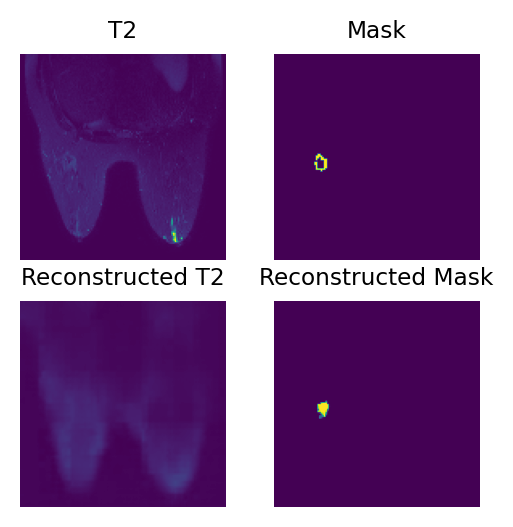

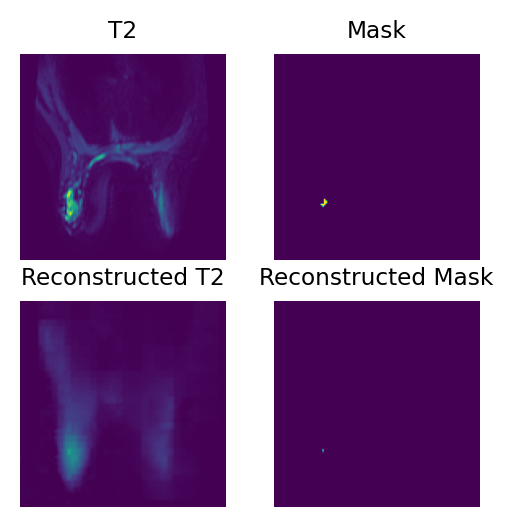

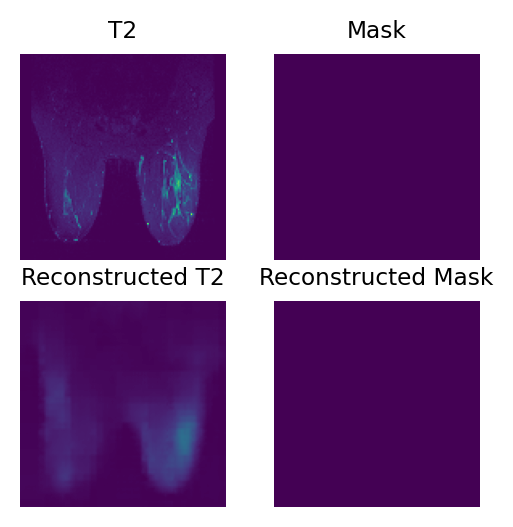

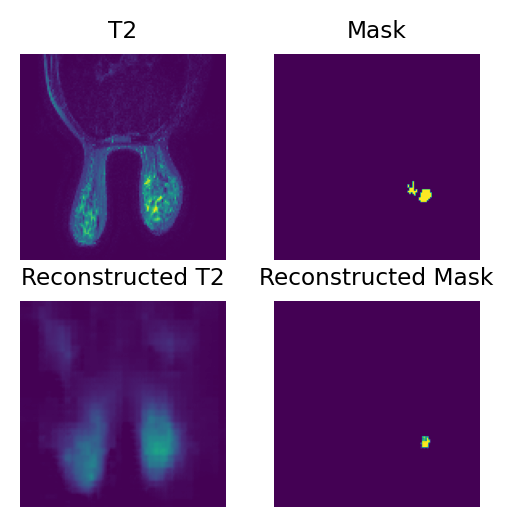

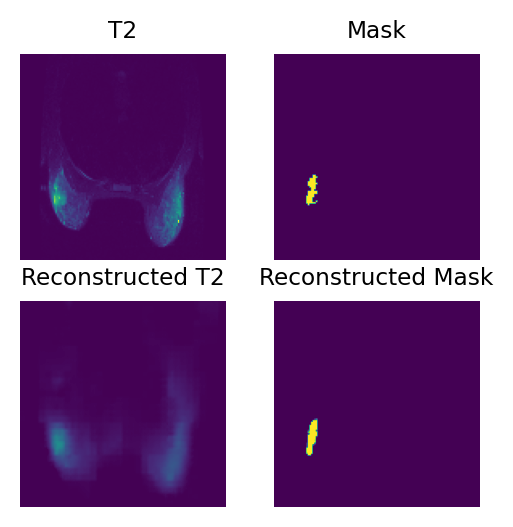

In [ ]:
idx = [1,4,8,9,15, 18, 19, 24, 27]

t2 = [t2_mask[id][0] for id in idx]
mask = [t2_mask[id][1] for id in idx]

t2h = [reconstructions[id][0] for id in idx]
maskh = [reconstructions[id][1] for id in idx]

for i in range(len(idx)):
  show_subplot(t2[i], mask[i], t2h[i].detach(), maskh[i].detach())

### Saving model

In [ ]:
# Create a folder called mri_models if there isn't one
#you may need to adjust the path to get access to T2_Mask_VAE.pth 
import os

path = '/content/drive/MyDrive/Colab Notebooks/mri_models' + "/T2_Mask_VAE.pth"
print(path)

# Save parameters
#torch.save(vae.state_dict(), path)

/content/drive/MyDrive/Colab Notebooks/mri_models/T2_Mask_VAE.pth


In [ ]:
# Instantiate model
vae_try = VariationalAutoencoder().to(device) 

# Load saved parameters
vae_try.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
test_recons = vae_try(t2_mask);
test_recons.shape

torch.Size([128, 2, 128, 128])